In [1]:
from eval import eval
import json
import pickle
import seaborn as sb
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

In [2]:
### load general data
relevance_scores = eval.load_rel_scores('data_2017-09/queries/relevance_scores.txt')
url_file_map = pickle.load(open('data_2017-09/url_file_map.pkl', 'rb'))
file_url_map = {url_file_map[url]['filename']: url for url in url_file_map}

In [6]:
### load run-specific data

queries_full = eval.load_query_ids('data_2017-09/queries/queries_val.tsv')

# full
bm25_full = eval.load_run('out/bm25_runs/v2_run.val_8_0.99.txt')
bm25_full_mrr = eval.compute_mrr10(relevance_scores, bm25_full, queries_full, raw=True)
bm25_full_p = eval.compute_p1(relevance_scores, bm25_full, queries_full, raw=True)


semantic_full = eval.load_run('out/semantic_runs/v2_run.val_full_msmarco-distilbert-cos-v5.txt')
semantic_full_mrr = eval.compute_mrr10(relevance_scores, semantic_full, queries_full, raw=True)
semantic_full_p = eval.compute_p1(relevance_scores, semantic_full, queries_full, raw=True)


semantic_finetune_full = eval.load_run('out/semantic_finetune_runs/train_bi-encoder-mnrl-msmarco-distilbert-cos-v5-queries-2022-06-01_12-04-50/eval/run.val_full.txt')
semantic_finetune_full_mrr = eval.compute_mrr10(relevance_scores, semantic_finetune_full, queries_full, raw=True)
semantic_finetune_full_p = eval.compute_p1(relevance_scores, semantic_finetune_full, queries_full, raw=True)


# onlylast
bm25_onlylast = eval.load_run('out/bm25_runs/v2_run.onlylast.val_4_0.9.txt')
bm25_onlylast_mrr = eval.compute_mrr10(relevance_scores, bm25_onlylast, queries_full, raw=True)
bm25_onlylast_p = eval.compute_p1(relevance_scores, bm25_onlylast, queries_full, raw=True)


semantic_onlylast = eval.load_run('out/semantic_runs/v2_run.val_onlylast_msmarco-distilbert-cos-v5.txt')
semantic_onlylast_mrr = eval.compute_mrr10(relevance_scores, semantic_onlylast, queries_full, raw=True)
semantic_onlylast_p = eval.compute_p1(relevance_scores, semantic_onlylast, queries_full, raw=True)


semantic_finetune_onlylast_full = eval.load_run('out/semantic_finetune_runs/train_bi-encoder-mnrl-msmarco-distilbert-cos-v5-queries_onlylast-2022-06-02_21-24-49/eval/run.val_onlylast.txt')
semantic_finetune_onlylast_mrr = eval.compute_mrr10(relevance_scores, semantic_finetune_onlylast_full, queries_full, raw=True)
semantic_finetune_onlylast_p = eval.compute_p1(relevance_scores, semantic_finetune_onlylast_full, queries_full, raw=True)


# removelast
bm25_removelast = eval.load_run('out/bm25_runs/run.removelast.val_7_0.99.txt')
bm25_removelast_mrr = eval.compute_mrr10(relevance_scores, bm25_removelast, queries_full, raw=True)
bm25_removelast_p = eval.compute_p1(relevance_scores, bm25_removelast, queries_full, raw=True)


semantic_removelast = eval.load_run('out/semantic_runs/run.val_removelast_msmarco-distilbert-cos-v5.txt')
semantic_removelast_mrr = eval.compute_mrr10(relevance_scores, semantic_removelast, queries_full, raw=True)
semantic_removelast_p = eval.compute_p1(relevance_scores, semantic_removelast, queries_full, raw=True)


semantic_finetune_removelast = eval.load_run('out/semantic_finetune_runs/train_bi-encoder-mnrl-msmarco-distilbert-cos-v5-queries_removelast-2022-05-22_18-44-28/eval/run.val_removelast.txt')
semantic_finetune_removelast_mrr = eval.compute_mrr10(relevance_scores, semantic_finetune_removelast, queries_full, raw=True)
semantic_finetune_removelast_p = eval.compute_p1(relevance_scores, semantic_finetune_removelast, queries_full, raw=True)




### Query length, MRR correlation

/home/kjros2/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kjros2/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kjros2/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

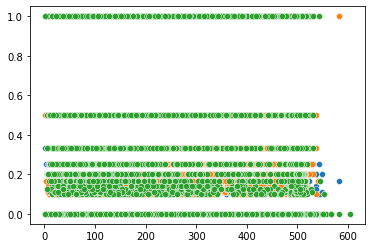

In [10]:
### Query length vs. MRR@10
lengths = {}
for query in queries_full:
    lengths[query] = len(queries_full[query].split(' '))

sb.scatterplot(list(lengths.values()), list(bm25_full_mrr.values()))
sb.scatterplot(list(lengths.values()), list(semantic_finetune_full_mrr.values()))
sb.scatterplot(list(lengths.values()), list(semantic_full_mrr.values()))
# Takeaway: no major visual difference


In [8]:
corr, _ = pearsonr(list(lengths.values()), list(bm25_full_mrr.values()))
print(corr)
corr, _ = pearsonr(list(lengths.values()), list(bm25_full_p.values()))
print(corr)


-0.20167615064719355
-0.17732113069403493


/home/kjros2/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

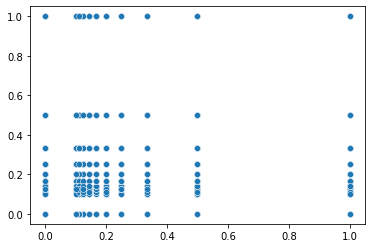

In [9]:
sb.scatterplot(list(bm25_full_mrr.values()), list(semantic_finetune_full_mrr.values()))


### Statistical significance testing

In [11]:
print(ttest_ind(list(bm25_full_mrr.values()), list(semantic_finetune_full_mrr.values())))
print(ttest_ind(list(bm25_full_mrr.values()), list(semantic_full_mrr.values())))
print(ttest_ind(list(semantic_finetune_full_mrr.values()), list(semantic_full_mrr.values())))



Ttest_indResult(statistic=-7.816899265638475, pvalue=5.5865454513825735e-15)
Ttest_indResult(statistic=12.652849342527968, pvalue=1.3319195116779942e-36)
Ttest_indResult(statistic=20.28278637078471, pvalue=7.2053947803362e-91)


In [5]:
def load_webpage_text(name):
    webpage = json.load(open('data_2017-09/webpages/' + name + '.json', 'r'))
    return webpage['contents'][:1000]

In [36]:
def find_differences(relevance_scores, run1, run2):
    infirst = []
    insecond = []
    inboth = []
    for query_id in run1:
        ground_truth = relevance_scores[query_id]
        if ground_truth in run1[query_id] and ground_truth not in run2[query_id]:
            infirst.append(query_id)
        if ground_truth in run2[query_id] and ground_truth not in run1[query_id]:
            insecond.append(query_id)
        if ground_truth in run1[query_id] and ground_truth in run2[query_id]:
            inboth.append(query_id)
    all_found = set(infirst).union(set(insecond)).union(set(inboth))
    missing = list(set(list(run1.keys())).difference(all_found))
    return infirst, insecond, missing
        

In [37]:
inbm25, insemanticfinetune, missing = find_differences(relevance_scores, bm25_full, semantic_finetune_full)
len(inbm25) + len(insemanticfinetune) + len(missing)

11092

Observations of full missed by both bm25 and semantic finetune (missing[:10])

1. '54110' --> BLM description / debate. even though missed still relevant. bm25 --> news articles about police and protests. semantic finetune --> wikipedia pages about individuals shot by police officers. 
2. '31481' --> about computer memory. Both returned somewhat relevant wiki pages. but induced demand is missed, possibly because the last comment is the url alone
3. '9643' --> cows and visions and colors. semantic finetune way off with mad cow disease. but bm25 gives color blindness and vision test examples. Many results with fragments. Likely artificially decreases scores, especially with wikipedia. More preprocessing needed.
4. '150732' --> trump wiretap. all results about wiretap. interestingly, they are all news articles. Top may be missed because a bit of irrelevant meta text at top of article. More preprocessing needed
5. '47250' --> trump exec actions but talking about veteren stuff. Mentioned in passing and a long comment. Difficult to recognize as a human that the url was there. 
6. '62920' --> england and countries. bm25 takes it literally and finds country wikipedia. semantic finetune finds articles based on urls already in comments (e.g.,Montevideo_Convention )

Observations of last missed by both bm25 and semantic finetune ()

In [69]:
query_id = '150732'
print('Query: ',queries_full[query_id])
print(file_url_map[relevance_scores[query_id]], relevance_scores[query_id])
print('\t', load_webpage_text(relevance_scores[query_id]))
#print('Run: ', semantic_finetune_full[query_id], '\n')
for x in semantic_finetune_full[query_id]:
    print(file_url_map[x],x)
    #print('\t', load_webpage_text(x))

Query:  Legal/political fallout - none. It was done with a warrant, which means that there was enough evidence to convince a judge to sign the warrant. If the Trump administration wants to try to make political hay about it, they are going to be going to bat for someone that is about to indicted (according to a new NY Times story), and that won't look so good. It certainly doesn't vindicate Trump, who was trying to paint the picture of a Nixonian/Watergate sort of scandal to spy on his campaign when he claimed that he and Trump Tower were the targets of wiretapping, though he should probably be worried about any conversations he had with Manafort during that time. So, smoking gun? It remains to be seen. <C> &gt;It was done with a warrant, which means that there was enough evidence to convince a judge to sign the warrant. Well, no. The issue was never just that a judge issued warrants for Russia witch hunt wiretaps (though many of us strongly suspect DNC meddling in that). The issue was